# LSTM Baseline Model Testing

## 0 Imports & Constants

In [303]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [304]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils.utils import load_time_series, add_lagged_data, scale_data, train_test_split_to_tensor
from utils.TimeSeriesDataset import TimeSeriesDataset

from baseline_model.LSTM import LSTM

In [305]:
DATA_FOLDER = Path("../data")
MULTIVARIATE_DATA_FOLDER = DATA_FOLDER / "multivariate"
UNIVARIATE_DATA_FOLDER = DATA_FOLDER / "univariate"
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 1000

In [306]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 2 Data

### Load Data

In [307]:
# Load data from csv
# -> convert Date column to datetime

df = load_time_series(f'{UNIVARIATE_DATA_FOLDER}/NVDA_open_high_low_close_adjClose_volume_99_24.csv')
df = df[['Close', 'Date']] # remember to put the target column first
df[:10]

,Close,Date
0,0.041016,1999-01-22
1,0.045313,1999-01-25
2,0.041797,1999-01-26
3,0.041667,1999-01-27
4,0.041536,1999-01-28
5,0.039583,1999-01-29
6,0.040365,1999-02-01
7,0.037240,1999-02-02
8,0.038021,1999-02-03
9,0.040104,1999-02-04


### Data Preprocessing

In [308]:
lag = 20
shifted_np_array = add_lagged_data(df, lag, ['Close'])
shifted_np_array.shape

(6371, 21, 1)

In [309]:
scaler = MinMaxScaler(feature_range=(0, 1))
shifted_np_array_same = scale_data(shifted_np_array, scaler)
shifted_np_array

array([[[7.30777425e-05],
        [7.23514250e-05],
        [6.34517959e-05],
        ...,
        [8.08905040e-05],
        [1.17913546e-04],
        [7.26666712e-05]],

       [[8.88764906e-05],
        [7.43579712e-05],
        [7.49006027e-05],
        ...,
        [7.95216202e-05],
        [8.08905040e-05],
        [1.17913546e-04]],

       [[1.16529988e-04],
        [9.04334932e-05],
        [7.69778461e-05],
        ...,
        [7.81422065e-05],
        [7.95216202e-05],
        [8.08905040e-05]],

       ...,

       [[9.49334727e-01],
        [9.32857901e-01],
        [9.72756186e-01],
        ...,
        [9.93229311e-01],
        [9.96082865e-01],
        [9.61608116e-01]],

       [[9.82782899e-01],
        [9.65965859e-01],
        [9.65725540e-01],
        ...,
        [9.73433092e-01],
        [9.93229311e-01],
        [9.96082865e-01]],

       [[1.00000000e+00],
        [1.00000000e+00],
        [1.00000000e+00],
        ...,
        [9.97662368e-01],
        [9.7343

In [310]:
X_train, y_train, X_test, y_test = train_test_split_to_tensor(shifted_np_array)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([6052, 20, 1]),
 torch.Size([6052, 1]),
 torch.Size([319, 20, 1]),
 torch.Size([319, 1]))

In [311]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [312]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [313]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 20, 1]) torch.Size([16, 1])


## 3 Model, Optimizer, Scheduler, Criterion

In [314]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=1, # number of features per time step
    hidden_size=4,
    num_stacked_layers=1
).to(device)

In [315]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001) #
criterion = nn.MSELoss()

## 4 Train Test Loop

In [316]:
def train_one_epoch(log_interval=100, use_scheduler=False):
    model.train()
    running_train_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        train_pred = model(x_batch)
        train_loss = criterion(train_pred, y_batch)
        running_train_loss += train_loss.item()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch_index % log_interval == 0:
            
            # log training loss 
            avg_train_loss_across_batches = running_train_loss / log_interval
            print(f'Batch: {batch_index}, Loss: {avg_train_loss_across_batches}')

            # update learning rate
            if(use_scheduler):
                current_learning_rate = scheduler.get_last_lr()
                scheduler.step(avg_train_loss_across_batches)
                if current_learning_rate != scheduler.get_last_lr():
                    print(f'INFO: Scheduler updated Learning rate from ${current_learning_rate} to {scheduler.get_last_lr()}')

            running_train_loss = 0.0 # reset running loss

In [317]:
def validate_one_epoch():
    model.eval()
    running_test_loss = 0.0

    with torch.inference_mode():
        for _, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            test_pred = model(x_batch)
            test_loss = criterion(test_pred, y_batch)
            running_test_loss += test_loss.item()

    # log validation loss
    avg_test_loss_across_batches = running_test_loss / len(test_loader)
    print(f'Validation Loss: {avg_test_loss_across_batches}')
    return avg_test_loss_across_batches

In [318]:
best_validation_loss = np.inf
patience = 10
num_epoch_without_improvement = 0
for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch + 1}')
    train_one_epoch()
    current_validation_loss = validate_one_epoch()
    
    # early stopping
    if current_validation_loss < best_validation_loss:
        best_validation_loss = current_validation_loss
        num_epoch_without_improvement = 0
    else:
        print(f'INFO: Validation loss did not improve in epoch {epoch + 1}')
        num_epoch_without_improvement += 1

    if num_epoch_without_improvement >= patience:
        print(f'Early stopping after {epoch + 1} epochs')
        break

    print(f'*' * 50)

Epoch: 1
Batch: 0, Loss: 0.0005458684265613556
Batch: 100, Loss: 0.01846199739142321
Batch: 200, Loss: 0.0022506671675364487
Batch: 300, Loss: 0.0017185055489244406
Validation Loss: 0.16039806129410863
**************************************************
Epoch: 2
Batch: 0, Loss: 1.9040802726522088e-05
Batch: 100, Loss: 0.0014713957910134922
Batch: 200, Loss: 0.0012217515821976123
Batch: 300, Loss: 0.0010896412754664198
Validation Loss: 0.10264986860565842
**************************************************
Epoch: 3
Batch: 0, Loss: 1.7666525673121213e-05
Batch: 100, Loss: 0.0007916007316089236
Batch: 200, Loss: 0.000632505249377573
Batch: 300, Loss: 0.0004460069527340238
Validation Loss: 0.06337119080126286
**************************************************
Epoch: 4
Batch: 0, Loss: 7.379810267593711e-07
Batch: 100, Loss: 0.0002217686779840733
Batch: 200, Loss: 0.00010482298783813348
Batch: 300, Loss: 4.2929909710665015e-05
Validation Loss: 0.043201648123795164
*****************************

### ['Close']
- **hidden: 4, stacked: 1 = 0.003**
    - **lag: 14 = 0.003**
    - lag: 7 = 0.004
    - lag: 30 = 0.004

### ['Close', 'Volume']
- **hidden: 6, stacked: 1 = 0.007**


## 5 Plot Predictions

### Inverse Transform

In [319]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [320]:
test_pred = test_pred.flatten()

dummies = np.zeros((X_test.shape[0], lag+1))
dummies[:, 0] = test_pred
dummies = scaler.inverse_transform(dummies)

test_pred = dc(dummies[:, 0])
test_pred

array([23.49371713, 23.02300107, 22.97166851, 23.93205173, 24.17485974,
       25.36046728, 25.64100653, 25.82553496, 26.10374216, 26.36608476,
       27.02545307, 26.73212587, 26.48326868, 26.34793919, 26.83576938,
       27.23624307, 27.62374609, 27.82757728, 27.4005041 , 26.8533393 ,
       26.92956603, 27.4121663 , 27.1068213 , 26.4864082 , 26.3908748 ,
       26.6390974 , 26.88078556, 27.48953842, 27.78385384, 27.09258539,
       27.02939221, 26.95311833, 26.24641751, 26.7979851 , 27.09187812,
       27.58314646, 28.64875473, 28.14916214, 27.73728951, 27.4790275 ,
       28.42794498, 28.93964772, 28.49009297, 28.71172002, 28.46542277,
       28.23177989, 28.74048456, 29.02186468, 29.89235502, 31.28555803,
       31.0726462 , 30.96460972, 30.52301576, 30.3423636 , 36.75603896,
       38.24004252, 39.34897737, 37.52070699, 38.88954236, 38.68359524,
       38.51906702, 38.0596438 , 37.01336186, 37.76505136, 38.08734546,
       38.72390214, 40.08129535, 41.87086985, 41.78161942, 41.76

In [321]:
train_pred = train_pred.flatten()

dummies = np.zeros((X_train.shape[0], lag+1))
dummies[:, 0] = train_pred
dummies = scaler.inverse_transform(dummies)

train_pred = dc(dummies[:, 0])
train_pred

array([ 0.18177861,  0.18212439,  0.18397903, ..., 23.57177295,
       23.31526735, 24.07342451])

In [322]:
dummies = np.zeros((X_train.shape[0], lag+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 0.04375   ,  0.045833  ,  0.049479  , ..., 23.28799988,
       24.18099929, 23.43600141])

In [323]:
dummies = np.zeros((X_test.shape[0], lag+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 22.96500047,  22.96600048,  24.06300004,  24.22800174,
        25.5409996 ,  25.72499954,  25.89999939,  26.19899855,
        26.46799937,  27.19100095,  26.77899865,  26.53100002,
        26.41000073,  26.98399881,  27.38299901,  27.77699915,
        27.96499913,  27.45299973,  26.88100167,  27.03700132,
        27.57899907,  27.16900072,  26.49500161,  26.46299931,
        26.75799844,  27.00200096,  27.66699998,  27.93100074,
        27.10400005,  27.11899824,  27.04199941,  26.24099898,
        26.95599852,  27.22599935,  27.74900083,  28.90999908,
        28.2099997 ,  27.80199941,  27.56200086,  28.68000063,
        29.15099961,  28.5709995 ,  28.88500079,  28.57799958,
        28.33999908,  28.95299952,  29.21299828,  30.17799844,
        31.67799824,  31.26399985,  31.1760009 ,  30.68799979,
        30.5380002 ,  37.98000054,  38.94599874,  40.11100097,
        37.83399903,  39.7699994 ,  39.32700072,  39.1709991 ,
        38.65399965,  37.47499728,  38.50999816,  38.77

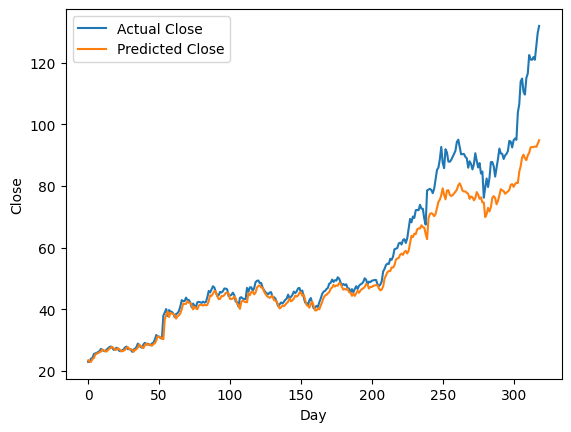

In [324]:
# plot test data

plt.plot(new_y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


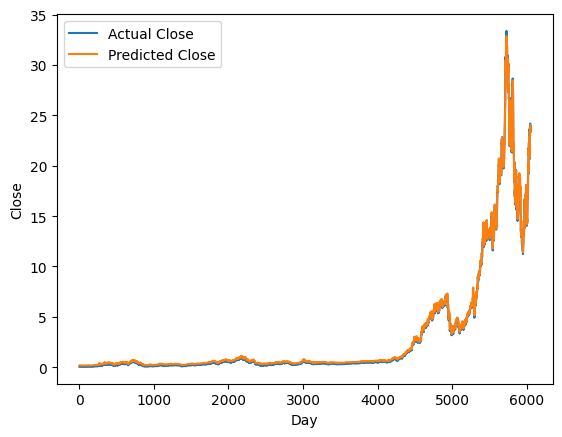

In [325]:
# plot train data

plt.plot(new_y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()
